In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
project_names = [
    "gender_female",
    "gender_male",
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
]
encoder_ids = [
    "mert_v1_95m",
    "whisper_large_v2",
    "muq_large_msd",
    "muq_mulan_large",
]
target_column = "genre"

In [ ]:
import json
import os
from typing import Literal

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_df_and_embeddings, get_cav_vectors

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]
audio_prefix = os.environ["AUDIO_PREFIX"]


In [80]:
def get_train_evaluation_metrics(
    project_name, encoder_id, train_type: Literal["ttest", "full"] = "full"
):
    metrics_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"evaluation_metrics_{train_type}_{project_name}.json",
    )
    metrics = json.load(open(metrics_dir))
    return metrics


plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["FreeSans"],
        "font.serif": ["FreeSerif"],
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "text.usetex": True,
    }
)

project_name_display_map = {
    "gender_female": "Sex - Female",
    "gender_male": "Sex - Male",
    "language_de": "Language - German",
    "language_en": "Language - English",
    "language_es": "Language - Spanish",
    "language_fr": "Language - French",
    "language_it": "Language - Italian",
    "language_ja": "Language - Japanese",
    "language_pt": "Language - Portuguese",
    "r&b": "R\\&B",
    "metal": "Metal*",
    "blues": "Blues*",
    "reggae": "Reggae*",
    "christian": "Christian*",
    "classical": "Classical*",
}

### Measure Model Bias Using TCAV


In [ ]:
from collections import defaultdict

from matplotlib import gridspec
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.stats import ttest_1samp


def calculate_tcav_scores(
    cav_weights: np.ndarray,
    cav_biases: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = np.array([np.array(x) for x in df_subset.embedding.values])
        for i, cav_weight in enumerate(cav_weights):
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_weight, cav_biases[i], target_embeddings)
            )

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction: bool = True,
    verbose: bool = True,
) -> dict[str, dict[str, float | list[float] | bool]]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction:
        target_p_value_str = (
            f"({target_p_value} / {len(tcav_scores)}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / len(tcav_scores)
    else:
        target_p_value_str = f"{target_p_value}"

    results = defaultdict(dict)
    for label, scores in tcav_scores.items():
        ttest_result = ttest_1samp(scores, 0.5)

        p_value = ttest_result.pvalue
        statistic = ttest_result.statistic

        results[label]["t_statistic"] = statistic.tolist()
        results[label]["p_value"] = p_value.tolist()
        results[label]["confidence_interval"] = [
            *ttest_result.confidence_interval(confidence_level=1 - target_p_value)
        ]
        results[label]["significant"] = p_value < target_p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {statistic:.4f}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return results


def plot_tcav_scores(
    results: dict,
    project_name: str,
    out_file_name: str | None = None,
    ci_boxplot: bool = False,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    def humaize_label(label):
        if label in project_name_display_map:
            return project_name_display_map[label]

        label = label.replace("_", " ")
        label = " ".join([x.capitalize() for x in label.split(" ")])
        return label

    colors = {
        "neutral": "#999999",
        "positive": "#56B4E9",
        "negative": "#E69F00",
    }

    encoders = [*results.keys()]
    n_encoders = len(results)

    sorted_labels = [
        *dict(
            sorted(
                results[encoders[0]]["tcav_scores"].items(),
                key=lambda x: np.mean(x[1]),
                reverse=False,
            )
        ).keys()
    ]

    fig = plt.figure(figsize=(18, 4))
    gs = gridspec.GridSpec(1, n_encoders, width_ratios=[1, 1, 1, 1], wspace=0)

    axes = [fig.add_subplot(gs[i]) for i in range(n_encoders)]

    for i, (encoder, ax) in enumerate(zip(encoders, axes)):
        sorted_data = [
            results[encoder]["tcav_scores"][label] for label in sorted_labels
        ]

        box_colors = [
            colors["neutral"]
            if not results[encoder]["ttest_results"][label]["significant"]
            else colors["positive"]
            if np.mean(scores) > 0.5
            else colors["negative"]
            for label, scores in zip(sorted_labels, sorted_data)
        ]

        if ci_boxplot:
            stats = []
            for label in sorted_labels:
                scores = results[encoder]["tcav_scores"][label]
                ci = results[encoder]["ttest_results"][label]["confidence_interval"]
                median = np.median(scores)
                mean = np.mean(scores)

                stats.append(
                    {
                        "label": label,
                        "med": results[encoder]["tcav_scores_full"][label][0],
                        "mean": mean,
                        "q1": ci[0],
                        "q3": ci[1],
                        "whislo": ci[0],
                        "whishi": ci[1],
                        "fliers": scores,
                    }
                )

            bplot = ax.bxp(
                stats,
                orientation="horizontal",
                showmeans=True,
                meanprops=dict(
                    marker="D",
                    markeredgecolor="black",
                    markerfacecolor="firebrick",
                    markersize=2,
                    alpha=0.0,
                ),
                boxprops=dict(linewidth=0.5, alpha=1, zorder=3),
                whiskerprops=dict(linewidth=0.5, alpha=0),
                capprops=dict(linewidth=0.5, alpha=0),
                medianprops=dict(linewidth=1.0, alpha=0, color="firebrick", zorder=4),
                flierprops=dict(
                    marker="o", color="black", alpha=0.005, markersize=2, zorder=1
                ),
                patch_artist=True,
            )

        else:
            bplot = ax.boxplot(
                sorted_data,
                vert=False,
                patch_artist=True,
                boxprops=dict(linewidth=0.5),
                flierprops=dict(marker="o", color="gray", alpha=0.5, markersize=3),
                whiskerprops=dict(linewidth=0.5),
                capprops=dict(linewidth=0.5),
                medianprops=dict(linewidth=1.5, color="firebrick"),
                meanprops=dict(
                    marker="D",
                    markeredgecolor="black",
                    markerfacecolor="firebrick",
                    markersize=3,
                ),
                showmeans=True,
            )

        for patch, color in zip(bplot["boxes"], box_colors):
            patch.set_facecolor(color)

        ax.axvline(0.5, color="black", linewidth=0.5)

        if i == 0:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([humaize_label(x) for x in sorted_labels])
        else:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([])

        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05, 1.05)

        ax.grid(axis="x", linestyle="--", linewidth=0.5)

        if i == n_encoders - 1:

            class MultiColorLegend:
                def __init__(self, colors):
                    self._colors = colors

            # Custom legend handler
            class MultiColorPatchHandler(HandlerBase):
                def create_artists(
                    self,
                    legend,
                    orig_handle,
                    xdescent,
                    ydescent,
                    width,
                    height,
                    fontsize,
                    trans,
                ):
                    patches = []
                    n = len(orig_handle._colors)
                    for i, color in enumerate(orig_handle._colors):
                        p = Rectangle(
                            (xdescent + i * width / n, ydescent),
                            width / n,
                            height,
                            facecolor=color,
                            edgecolor="black",
                            transform=trans,
                            linewidth=0.3,
                        )
                        patches.append(p)
                    return patches

            # Create dummy legend object
            combined_bias = MultiColorLegend(
                [colors["positive"], colors["negative"], colors["neutral"]]
            )

            # Add to legend
            legend_elements = [
                combined_bias,
                #                Line2D(
                #                    [0],
                #                   [0],
                #                   marker="|",
                #                  linestyle="None",
                #                  color="firebrick",
                #                  markersize=12,
                #                  markeredgewidth=2,
                #                 label="Median",
                #            ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    linestyle="None",
                    color="gray",
                    alpha=0.5,
                    markersize=4,
                    label="Individual sample",
                ),
            ]

            plt.legend(
                handles=legend_elements,
                labels=["95\\% CI", "TCAV sample"],
                handler_map={MultiColorLegend: MultiColorPatchHandler()},
                loc="lower right",
                fontsize="x-small",
            )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        test_acc = results[encoder]["metrics_ttest_mean_acc"]
        ax.set_title(
            f"Encoder: {encoder} (Ø Test Acc: {test_acc:.2f})",
            fontsize=12,
            pad=10,
            loc="left",
        )

    # fig.suptitle(
    #    rf"Bias Evaluation for Concept: \textit{{{humaize_label(project_name)}}}",
    #    fontsize=16,
    #    y=1.05,
    # )

    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05, left=0.05, right=0.98, wspace=0)

    if out_file_name:
        fig.savefig(out_file_name, dpi=300, bbox_inches="tight")

    plt.show()


Evaluating gender_female with mert_v1_95m on genre
Evaluating gender_female with whisper_large_v2 on genre
Evaluating gender_female with muq_large_msd on genre
Evaluating gender_female with muq_mulan_large on genre


findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

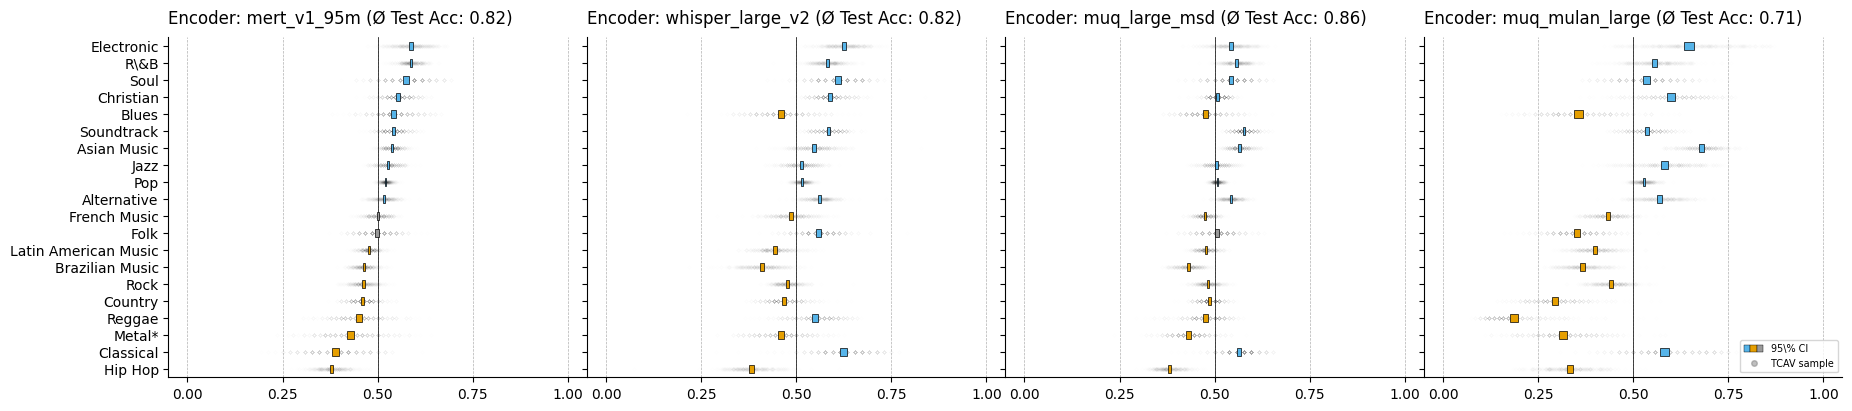

Evaluating gender_male with mert_v1_95m on genre
Evaluating gender_male with whisper_large_v2 on genre
Evaluating gender_male with muq_large_msd on genre


KeyboardInterrupt: 

In [ ]:
table_metrics = {}

for project_name in project_names:
    project_metrics = defaultdict(dict)

    for encoder_id in encoder_ids:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = load_df_and_embeddings(
            project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
        )

        cav_weights_full = get_cav_vectors(project_name, encoder_id, "weight_full")
        cav_weights_ttest = get_cav_vectors(project_name, encoder_id, "weight_ttest")

        cav_biases_full = get_cav_vectors(project_name, encoder_id, "bias_full")
        cav_biases_ttest = get_cav_vectors(project_name, encoder_id, "bias_ttest")

        tcav_scores_full = calculate_tcav_scores(
            cav_weights_full,
            cav_biases_full,
            df_test,
            target_column,
        )

        tcav_scores = calculate_tcav_scores(
            cav_weights_ttest,
            cav_biases_ttest,
            df_test,
            target_column,
        )

        ttest_result = t_test_on_tcav_scores(tcav_scores, verbose=False)

        project_metrics[encoder_id]["tcav_scores"] = tcav_scores
        project_metrics[encoder_id]["ttest_results"] = ttest_result

        project_metrics[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )
        mean_test_acc = np.mean(
            [x["accuracy"] for x in project_metrics[encoder_id]["metrics_ttest"]]
        )
        project_metrics[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        project_metrics[encoder_id]["tcav_scores_full"] = tcav_scores_full

    file_name = os.path.join(
        "plots",
        f"tcav_ttest_{project_name}_{target_column}.png",
    )

    plot_tcav_scores(
        project_metrics,
        project_name,
        out_file_name=file_name,
        ci_boxplot=True,
    )

    table_metrics[project_name] = project_metrics


### Create Train Metrics Table


In [ ]:
import re
from collections import defaultdict


def format_table_models_with_metrics_columns(data):
    def escape_latex(s):
        if not isinstance(s, str):
            s = str(s)
        special_chars = {
            "&": r"\&",
            "%": r"\%",
            "$": r"\$",
            "#": r"\#",
            "_": r"\_",
            "{": r"\{",
            "}": r"\}",
            "~": r"\textasciitilde{}",
            "^": r"\textasciicircum{}",
            "\\": r"\textbackslash{}",
        }
        regex = re.compile("|".join(re.escape(key) for key in special_chars.keys()))
        return regex.sub(lambda match: special_chars[match.group()], s)

    models = list(data[project_names[0]].keys())

    metrics = {
        "Full Acc": ["metrics_full", "accuracy"],
        "Ø TTest Acc": ["metrics_ttest_mean_acc"],
    }

    # --- Header Rows ---
    header1 = ["\\textbf{}"] + [
        f"\\multicolumn{{{len(metrics)}}}{{c}}{{{escape_latex(m)}}}" for m in models
    ]
    header2 = [""] + [*metrics.keys()] * len(models)

    # --- Data Rows ---
    rows = []
    for pn in project_names:
        row = [project_name_display_map[pn]]
        for model in models:
            for metric_name in metrics:
                val = data[pn][model].copy()
                for locator in metrics[metric_name]:
                    val = val.get(locator)
                row.append(f"{val:.2f}")
        rows.append(row)

    num_cols = len(header2)
    col_format = "l" + " c" * (num_cols - 1)

    # --- LaTeX Table Code ---
    table = "\\begin{table}[ht]\n\\centering\n"
    table += "\\renewcommand{\\arraystretch}{1.}\n"
    table += "\\setlength{\\tabcolsep}{2pt} \n"
    table += "\\small\n"
    table += "\\begin{tabular}{" + col_format + "}\n"
    table += "\\toprule\n"
    table += " & ".join(header1) + " \\\\\n"
    table += " & ".join(header2) + " \\\\\n"
    table += "\\midrule\n"
    for row in rows:
        table += " & ".join(row) + " \\\\\n"
    table += "\\bottomrule\n"
    table += "\\end{tabular}\n"
    table += "\\caption{{Some Caption}}\n"
    table += "\\label{{some:label}}\n"
    table += "\\end{table}"

    # --- Full LaTeX Document ---
    document = (
        r"""\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\geometry{margin=1in}
\usepackage{booktabs}
\usepackage{multirow}
\title{Some Table}
\begin{document}
\maketitle
"""
        + "\n"
        + table
        + "\n"
        + r"\end{document}"
    )

    return document


In [ ]:
table_metrics = {}

for project_name in project_names:
    project_metrics = defaultdict(dict)

    for encoder_id in encoder_ids:
        project_metrics[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )

        mean_test_acc = np.mean(
            [x["accuracy"] for x in project_metrics[encoder_id]["metrics_ttest"]]
        )
        project_metrics[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        project_metrics[encoder_id]["metrics_full"] = get_train_evaluation_metrics(
            project_name, encoder_id, "full"
        )

    table_metrics[project_name] = project_metrics

open("latex.tex", "w").write(format_table_models_with_metrics_columns(table_metrics))


1399

In [ ]:
!pdflatex latex.tex 

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./latex.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty)
(/usr/share/texlive/texmf-dist/tex/latex/multirow/multirow.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-pdftex.def)
No file latex.aux.
*geometry* driver: auto-detecting
*geometry* de

### Concept De-biasing


In [53]:
import os

import numpy as np
import pandas as pd
import s3fs
from cavmir.utils import load_df_and_embeddings, train_cav_classifier, get_cav_vectors
from collections import defaultdict
import matplotlib.pyplot as plt

s3 = s3fs.S3FileSystem()

embedding_prefix = os.environ["EMBEDDING_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]


def equally_sample_from_df(
    df: pd.DataFrame, col: str, val: object, n: int, random_state: int
) -> pd.DataFrame:
    df_positive = df[df[col] == val]
    df_negative = df[df[col] != val]

    df_positive_sample = df_positive.sample(n=n // 2, random_state=random_state)
    df_negative_sample = df_negative.sample(n=n // 2, random_state=random_state)

    return pd.concat([df_positive_sample, df_negative_sample])


#### Train Hip-Hop Classifier


In [21]:
project_name = "genre_hip_hop"
encoder_id = "muq_mulan_large"

epochs = 10000
learning_rate = 0.004
embedding_dim = 512
dropout = 0.0

In [8]:
# remove last folder and replace by "dataset_hip_hop"
dataset_hip_hop_prefix = dataset_prefix.split("/")[:-2]
dataset_hip_hop_prefix.append("dataset_hip_hop")
dataset_hip_hop_prefix = "/".join(dataset_hip_hop_prefix)


In [9]:
train_val_split = 0.9

df = load_df_and_embeddings(
    project_name,
    "train",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test = load_df_and_embeddings(
    project_name,
    "test",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test_concept = equally_sample_from_df(
    df[df.genre == "hip_hop"], "gender", "male", 200, 0
)

df = df.drop(df_test_concept.index)
df = df.drop(df[df.genre != "hip_hop"].sample(200, random_state=0).index)

training_size = int(len(df) * train_val_split)
validation_size = int(len(df) - training_size)


Epoch 100/10000
Epoch 100 Train Loss: 0.2765
Epoch 100 Validation Loss: 0.2778
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 200/10000
Epoch 200 Train Loss: 0.2259
Epoch 200 Validation Loss: 0.2288
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 300/10000
Epoch 300 Train Loss: 0.2103
Epoch 300 Validation Loss: 0.2135
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 400/10000
Epoch 400 Train Loss: 0.2028
Epoch 400 Validation Loss: 0.2059
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 500/10000
Epoch 500 Train Loss: 0.1982
Epoch 500 Validation Loss: 0.2010
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 600/10000
Epoch 600 Train Loss: 0.1950
Epoch 600 Validation Loss: 0.1974
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 700/10000
Epoch 700 Train Loss: 0.1924
Epoch 700 Validation Loss: 0.1946
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 800/10000
Epoch 800 Train Loss: 0.1903
Epoch 800 Validation Los

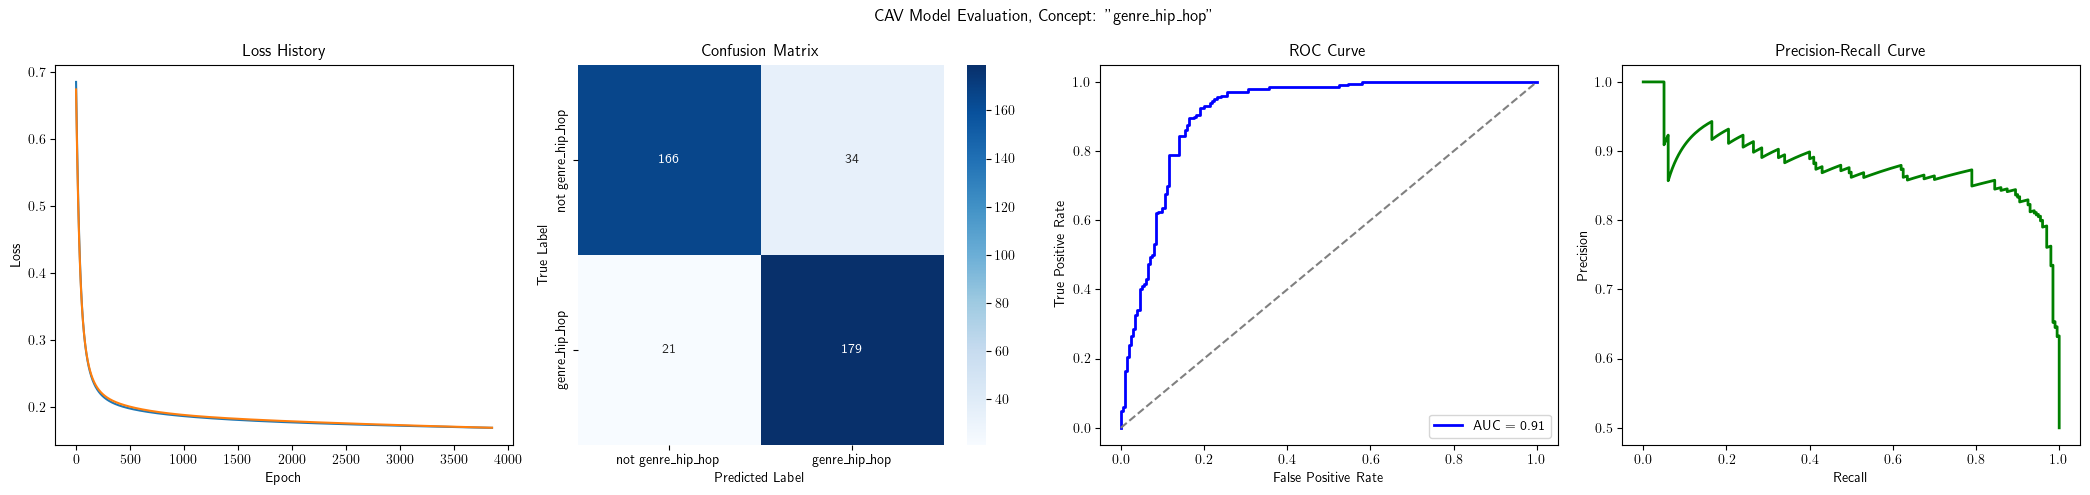

In [10]:
cav_weight, cav_bias, metrics = train_cav_classifier(
    random_state=0,
    df=df,
    df_test=df_test,
    project_name=project_name,
    training_sample_size=training_size,
    validation_sample_size=validation_size,
    embedding_dim=embedding_dim,
    epochs=epochs,
    learning_rate=learning_rate,
    dropout_rate=dropout,
    plot_evaluation=True,
    verbose_steps=100,
)

#### Mix Hip Hop CAV with gender CAVs


In [93]:
def track_activations_by_cav_vector(target_embeddings, cav_weight, cav_bias):
    return (target_embeddings @ cav_weight.T) + cav_bias


def male_in_top_100(target_activations):
    return sum(np.argsort(target_activations[:, 0])[::-1][:100] < 100) / 100


def mix_weights(cav_weight, mix_in_cav_weight, lambda_, mode: Literal["add", "remove"]):
    if mode == "add":
        return cav_weight + (lambda_ * mix_in_cav_weight)
    elif mode == "remove":
        return cav_weight - (lambda_ * mix_in_cav_weight)
    else:
        raise ValueError("Mode must be either 'add' or 'remove'.")

In [51]:
cav_weight_male = get_cav_vectors("gender_male", encoder_id, "weight_full")
cav_weight_female = get_cav_vectors("gender_female", encoder_id, "weight_full")

target_embeddings = np.array([np.array(x) for x in df_test_concept.embedding.values])


In [94]:
lambdas = []
male_in_top_100s = defaultdict(list)

for _lambda in np.linspace(0, 5, 101):
    lambdas.append(_lambda)

    new_cav_weight = mix_weights(cav_weight, cav_weight_male, _lambda, mode="remove")
    target_activations = (
        np.dot(target_embeddings, np.atleast_2d(new_cav_weight).T) + cav_bias
    )
    male_in_top_100s["male"].append(male_in_top_100(target_activations))

    ####

    new_cav_weight = mix_weights(cav_weight, cav_weight_female, _lambda, mode="add")
    target_activations = (
        np.dot(target_embeddings, np.atleast_2d(new_cav_weight).T) + cav_bias
    )
    male_in_top_100s["female"].append(male_in_top_100(target_activations))


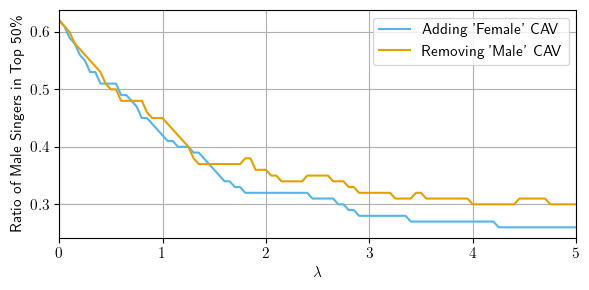

In [100]:
plt.figure(figsize=(6, 3))


plt.plot(
    lambdas, male_in_top_100s["female"], color="#56B4E9", label="Adding 'Female' CAV"
)
plt.plot(
    lambdas, male_in_top_100s["male"], color="#E69F00", label="Removing 'Male' CAV"
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Ratio of Male Singers in Top 50\\%")
plt.legend(loc="upper right")

plt.title("")

plt.xlim([0, 5])
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 3))


plt.plot(
    lambdas, male_in_top_100s["female"], color="#56B4E9", label="Adding 'Female' CAV"
)
plt.plot(
    lambdas, male_in_top_100s["male"], color="#E69F00", label="Removing 'Male' CAV"
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Ratio of Male Singers in Top 50\\%")
plt.legend(loc="upper right")

plt.title("")

plt.xlim([0, 5])
plt.grid()

plt.show()

RuntimeError: latex was not able to process the following string:
b"Removing 'Male' \\U0001f92e CAV"

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpwajvk8zd 000a8f859086591a92486b9f4535a0b3cc5048e6315f90a20066392695b4e4ca.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./000a8f859086591a92486b9f4535a0b3cc5048e6315f90a20066392695b4e4ca.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 000a8f859086591a92486b9f4535a0b3cc5048e6315f90a20066392695b4e4ca.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character 🤮 (U+1F92E)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily Removing 'Male' 🤮
                                     CAV}%
No pages of output.
Transcript written on tmpwajvk8zd/000a8f859086591a92486b9f4535a0b3cc5048e6315f9
0a20066392695b4e4ca.log.




<Figure size 600x300 with 1 Axes>